In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, scale, MinMaxScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
plt.rcParams['figure.figsize'] = 16,12
%matplotlib inline

In [59]:
# Read data from files
df_train = pd.read_csv('train.csv')
df_holdout = pd.read_csv('test.csv')

# Shortcut lists
personal = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact']
bank = ['month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
macro = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [60]:
df_train[personal].head()

,age,job,marital,education,default,housing,loan,contact
0,54,technician,married,professional.course,unknown,no,no,cellular
1,36,services,single,basic.4y,no,no,no,telephone
2,53,blue-collar,married,basic.4y,no,yes,no,cellular
3,34,blue-collar,married,basic.9y,no,yes,yes,telephone
4,29,services,single,university.degree,no,yes,no,telephone


In [61]:
df_train[bank].head()

,month,day_of_week,duration,campaign,pdays,previous,poutcome
0,aug,tue,87,1,999,0,nonexistent
1,may,mon,291,1,999,0,nonexistent
2,aug,mon,182,1,999,0,nonexistent
3,may,wed,180,2,999,0,nonexistent
4,aug,fri,6,1,999,0,nonexistent


In [62]:
df_train[macro].head()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.4,93.444,-36.1,4.963,5228.1
1,1.1,93.994,-36.4,4.857,5191.0
2,1.4,93.444,-36.1,4.965,5228.1
3,1.1,93.994,-36.4,4.857,5191.0
4,-1.7,94.027,-38.3,0.890,4991.6


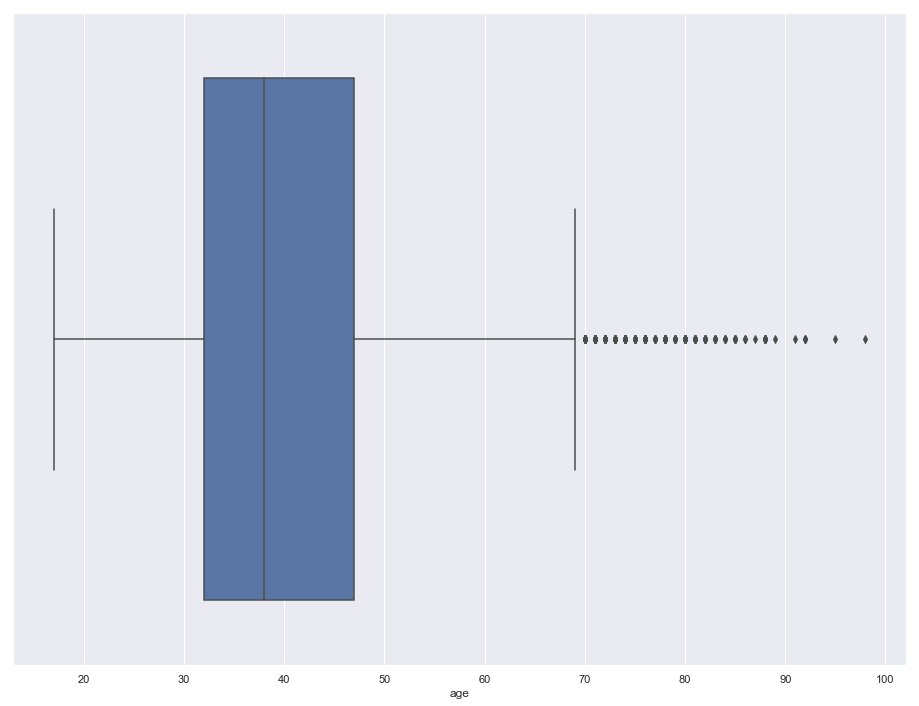

In [63]:
# Check outliers
sns.set(style='darkgrid', rc={'figure.figsize':(16,12)})
sns.boxplot(df_train.age);

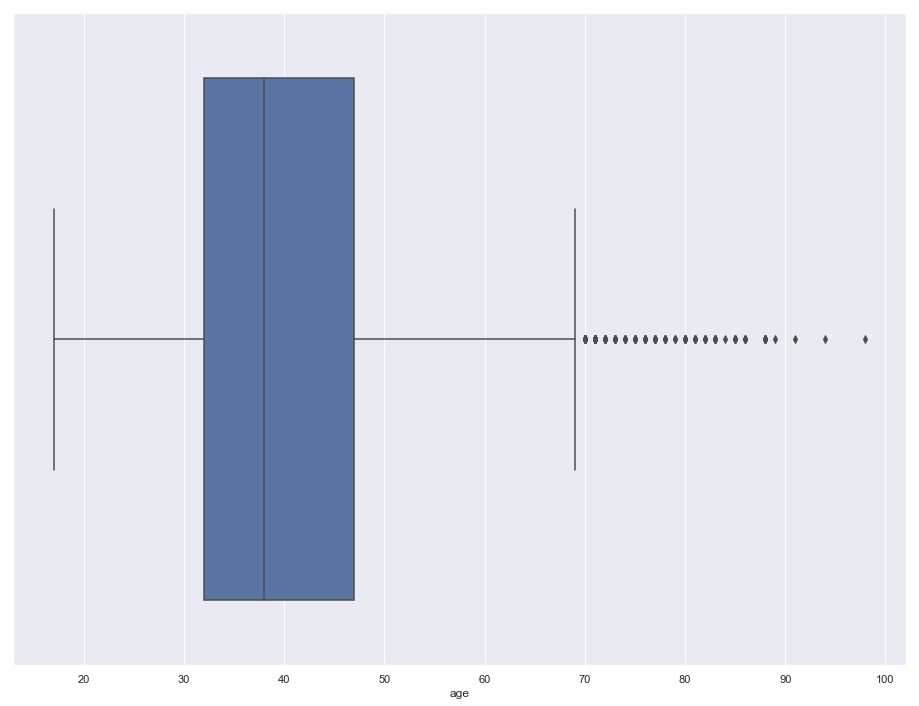

In [64]:
# Check outliers
sns.set(style='darkgrid', rc={'figure.figsize':(16,12)})
sns.boxplot(df_holdout.age);

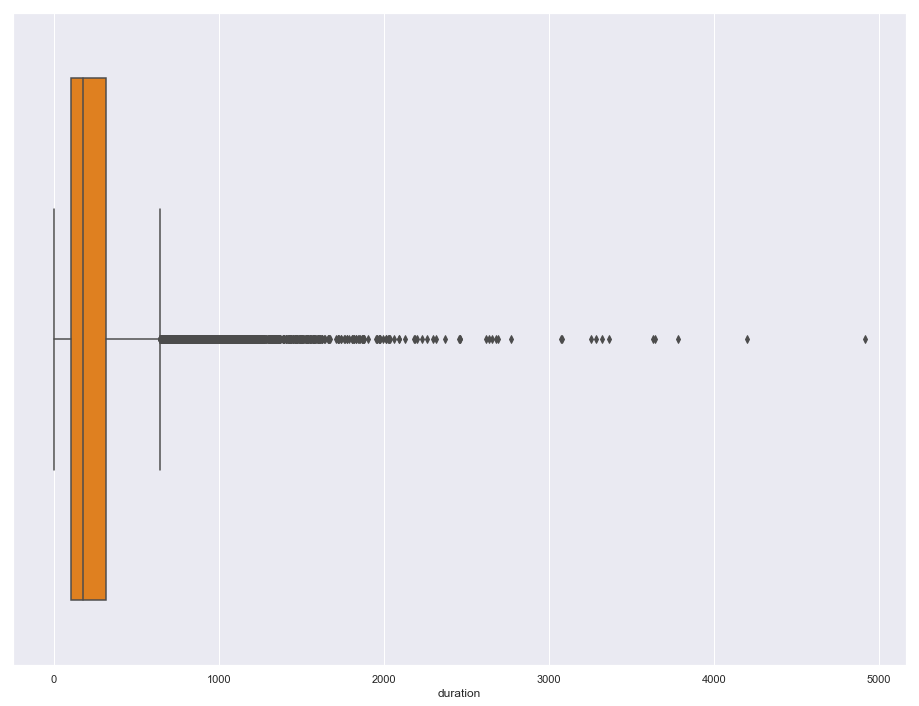

In [65]:
# Check outliers
sns.boxplot(df_train.duration, palette='autumn');

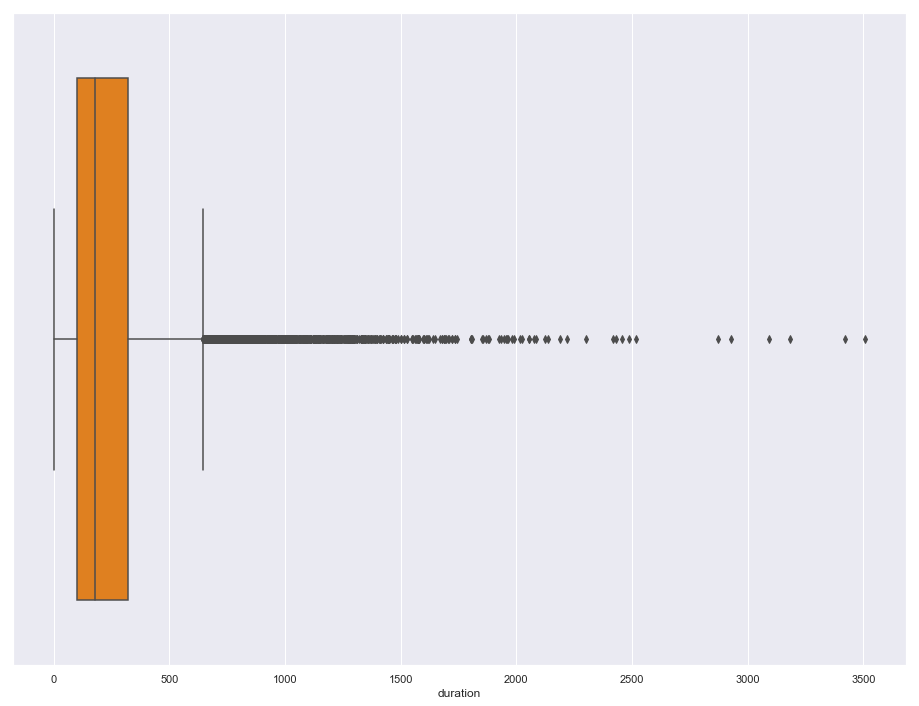

In [66]:
# Check outliers
sns.boxplot(df_holdout.duration, palette='autumn');

In [67]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24712.0,40.030188,10.462301,17.000,32.000,38.000,47.000,98.000
duration,24712.0,258.345298,261.573344,0.000,102.000,180.000,319.000,4918.000
campaign,24712.0,2.580163,2.776757,1.000,1.000,2.000,3.000,43.000
pdays,24712.0,963.558797,184.224885,0.000,999.000,999.000,999.000,999.000
previous,24712.0,0.171900,0.491511,0.000,0.000,0.000,0.000,6.000
emp.var.rate,24712.0,0.082713,1.572300,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,24712.0,93.576386,0.579548,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,24712.0,-40.516077,4.639359,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,24712.0,3.619397,1.737099,0.634,1.344,4.857,4.961,5.045
nr.employed,24712.0,5166.988111,72.516221,4963.600,5099.100,5191.000,5228.100,5228.100


In [68]:
df_holdout.describe().T

,count,mean,std,min,25%,50%,75%,max
age,16476.0,40.014870,10.359684,17.000,32.000,38.000,47.000,98.000
duration,16476.0,258.194586,255.807695,1.000,103.000,180.000,320.000,3509.000
campaign,16476.0,2.548738,2.759845,1.000,1.000,2.000,3.000,56.000
pdays,16476.0,960.850571,190.862870,0.000,999.000,999.000,999.000,999.000
previous,16476.0,0.174557,0.499953,0.000,0.000,0.000,0.000,7.000
emp.var.rate,16476.0,0.080645,1.568994,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,16476.0,93.574583,0.577792,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,16476.0,-40.482387,4.611474,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,16476.0,3.624132,1.730512,0.634,1.344,4.857,4.961,5.045
nr.employed,16476.0,5167.107605,71.854828,4963.600,5099.100,5191.000,5228.100,5228.100


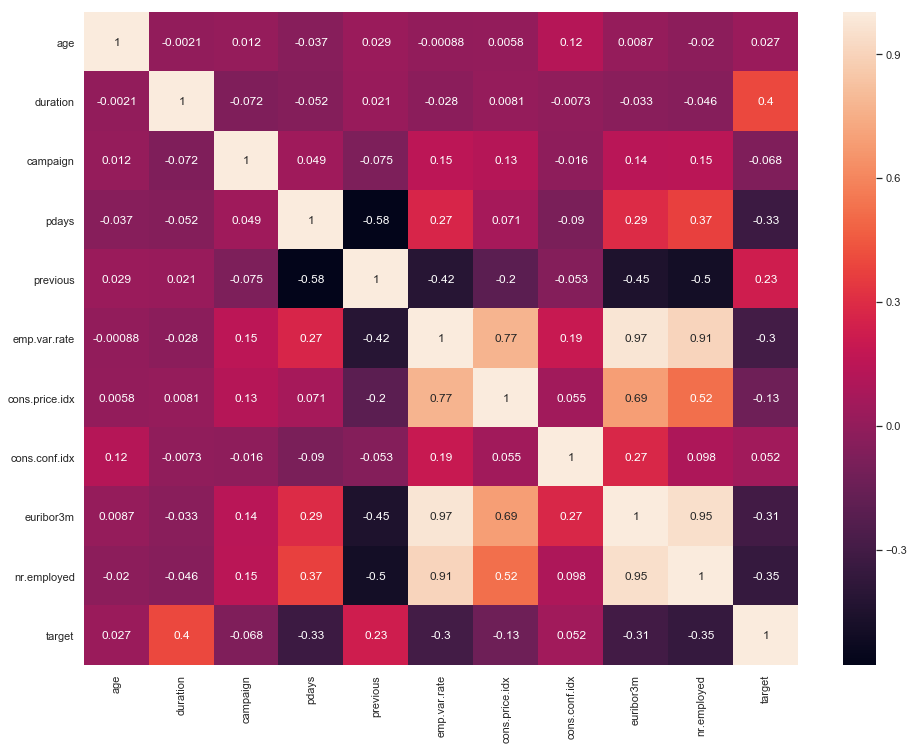

In [69]:
# Check corellation
sns.heatmap(df_train.corr(), annot=True);

In [70]:
def preproc_lr(df):    
    # Unify jobs by income
    df['job'] = np.where(df['job'] == 'technician', 'middle', df['job'])
    df['job'] = np.where(df['job'] == 'services', 'middle', df['job'])
    df['job'] = np.where(df['job'] == 'blue-collar', 'middle', df['job'])
    df['job'] = np.where(df['job'] == 'self-employed', 'middle', df['job'])

    df['job'] = np.where(df['job'] == 'retired', 'low', df['job'])
    df['job'] = np.where(df['job'] == 'unemployed', 'low', df['job'])
    df['job'] = np.where(df['job'] == 'housemaid', 'low', df['job'])
    df['job'] = np.where(df['job'] == 'student', 'low', df['job'])

    df['job'] = np.where(df['job'] == 'admin.', 'high', df['job'])
    df['job'] = np.where(df['job'] == 'management', 'high', df['job'])
    df['job'] = np.where(df['job'] == 'entrepreneur', 'high', df['job'])
    
    # Defining the time consequence (compare macroeconomic figures in Internet)
    def year(x):
        if x['nr.employed'] in [5191, 5228.1, 5195.8, 5176.3]:
            return 2008
        elif x['nr.employed'] in [5099.1, 5076.2, 5017.5, 5023.5]:
            return 2009
        else:
            return 2010
    df['year'] = df.apply(year, axis=1)
    
    # Make hash for different periods
    df['ind_day'] = df['cons.price.idx'].astype('str') + '_'\
                    +df['cons.conf.idx'].astype('str') + '_'\
                    +df['nr.employed'].astype('str') + '_'\
                    +df['emp.var.rate'].astype('str') + '_'\
                    +df['euribor3m'].astype('str') + '_'\
                    +df['day_of_week'].astype('str') + '_'\
                    +df['month'].astype('str') + '_'\
                    +df['year'].astype('str')
    df['ind_week'] = df['cons.price.idx'].astype('str') + '_'\
                +df['cons.conf.idx'].astype('str') + '_'\
                +df['month'].astype('str') + '_'\
                +df['emp.var.rate'].astype('str') + '_'\
                +df['nr.employed'].astype('str') + '_'\
                +df['day_of_week'].astype('str')
    df['ind_month'] = df['cons.price.idx'].astype('str') + '_'\
                    +df['cons.conf.idx'].astype('str') + '_'\
                    +df['month'].astype('str') + '_'\
                    +df['emp.var.rate'].astype('str') + '_'\
                    +df['nr.employed'].astype('str')
    df['ind_quarter'] = df['nr.employed'].astype('str') + '_'\
                    +df['emp.var.rate'].astype('str')
    
    # One-Hot-Encoding categorial features
    ohe_columns = ['job', 'education', 'default', 'housing', 'loan', 'month', 'year', 
                   'contact', 'ind_day', 
                   'ind_week', 
                   'ind_month', 'ind_quarter', 'poutcome']
    for f in ohe_columns:
        zf = pd.get_dummies(df[f], prefix=f)
        df[zf.columns] = zf
        df.drop(f, axis=1, inplace=True)
    
    # Scaling of 'age' feature
    scaler_list = ['age']
    for x in scaler_list:
        df[x] = scale(df[x])
    
    # Drop features
    df.drop(['_id', 'day_of_week', 'marital', 'euribor3m', 'nr.employed'], axis=1, inplace=True)
    
    return df

In [71]:
df_train = df_train.pipe(preproc_lr)
df_holdout = df_holdout.pipe(preproc_lr)

# Cut outliers in train
df_train = df_train[df_train['age']<69]
df_train = df_train[df_train['duration']<590]

c:\users\rncb\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\rncb\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [72]:
# Not every preiod hash coincide in dfs, so we have to select only features (after OHE 
# every hash got a feature) intersected among sets
common_columns = set(df_train.columns).intersection(set(df_holdout.columns))
df_train = df_train[list(common_columns)+['target']]
df_holdout = df_holdout[list(common_columns)]

In [73]:
### LOGISTIC REGRESSION
X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict_proba = lr.predict_proba(X_test)
roc_auc_score(y_test, lr_predict_proba[:, 1])

c:\users\rncb\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9511011396604616

In [74]:
# GridSearcCV
C = np.linspace(0.1, 3, 10)

lr_param_grid_l1_standart = {'C':C,
                             'penalty':['l1']}
grid_lr_l1_standart = GridSearchCV(lr, param_grid=lr_param_grid_l1_standart, 
                          scoring='roc_auc', n_jobs=-1, cv=5)
grid_lr_l1_standart.fit(X, y)

lr_param_grid_l1_balanced = {'C':C, 
                    'class_weight':['balanced'],
                    'penalty':['l1']}
grid_lr_l1_balanced = GridSearchCV(lr, param_grid=lr_param_grid_l1_balanced, 
                          scoring='roc_auc', n_jobs=-1, cv=5)
grid_lr_l1_balanced.fit(X, y)

lr_param_grid_l2_standart = {'C':C,
                             'penalty':['l2']}
grid_lr_l2_standart = GridSearchCV(lr, param_grid=lr_param_grid_l2_standart, 
                          scoring='roc_auc', n_jobs=-1, cv=5)
grid_lr_l2_standart.fit(X, y)

lr_param_grid_l2_balanced = {'C':C, 
                    'class_weight':['balanced'],
                    'penalty':['l2']}
grid_lr_l2_balanced = GridSearchCV(lr, param_grid=lr_param_grid_l2_balanced, 
                          scoring='roc_auc', n_jobs=-1, cv=5)
grid_lr_l2_balanced.fit(X, y)


c:\users\rncb\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\rncb\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\rncb\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\rncb\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([0.1    , 0.42222, 0.74444, 1.06667, 1.38889, 1.71111, 2.03333,
       2.35556, 2.67778, 3.     ]), 'class_weight': ['balanced'], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [75]:
best_score = max(grid_lr_l1_standart.best_score_,
              grid_lr_l1_balanced.best_score_,
              grid_lr_l2_standart.best_score_,
              grid_lr_l2_balanced.best_score_)
best_c = grid_lr_l1_standart.best_params_['C']
best_l = grid_lr_l1_standart.best_params_['penalty']

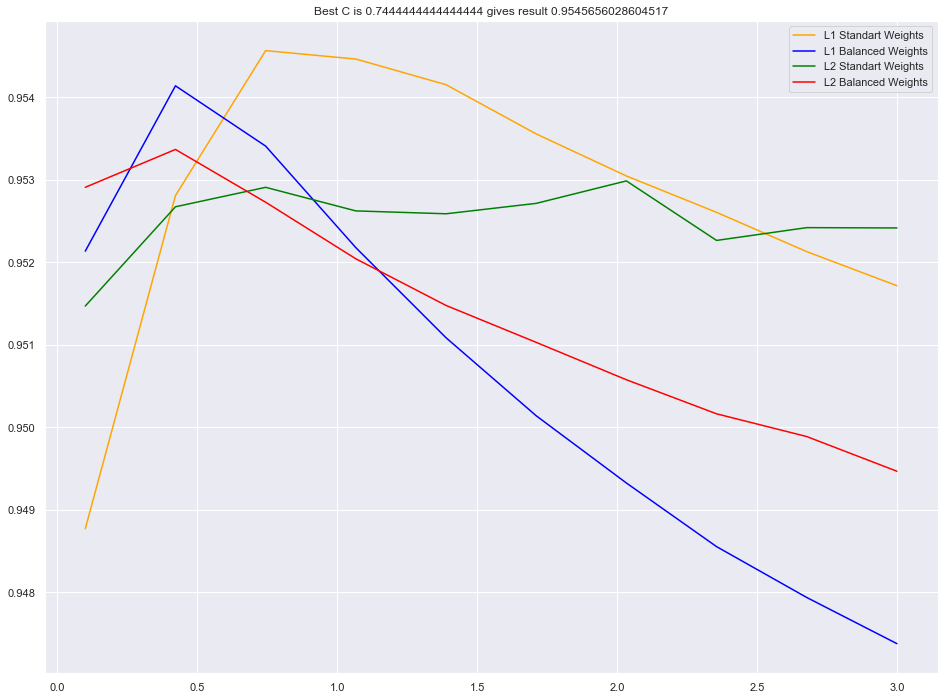

In [76]:
plt.figure(figsize=[16,12])
plt.plot(C, grid_lr_l1_standart.cv_results_['mean_test_score'], 
         color='orange', label='L1 Standart Weights')
plt.plot(C, grid_lr_l1_balanced.cv_results_['mean_test_score'], 
         color='blue', label='L1 Balanced Weights')
plt.plot(C, grid_lr_l2_standart.cv_results_['mean_test_score'], 
         color='green', label='L2 Standart Weights')
plt.plot(C, grid_lr_l2_balanced.cv_results_['mean_test_score'], 
         color='red', label='L2 Balanced Weights')
plt.title('Best C is {0} gives result {1}'.format(best_c, 
                                               best_score))
plt.legend()
plt.grid(True)

In [77]:
# Apply best params
lr = LogisticRegression(C=best_c,
                       penalty=best_l)
lr.fit(X, y)

# CV check
lr_cv = cross_val_score(lr, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
lr_cv_best = lr_cv.mean()
print('Best result with LogisticRegression: {}'.format(lr_cv.mean()))

c:\users\rncb\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best result with LogisticRegression: 0.9546440181511612


In [78]:
### KNN

# Read data from files
df_train = pd.read_csv('train.csv')
df_holdout = pd.read_csv('test.csv')

In [79]:
def preproc_knn(df):
    df.drop(['_id'], axis=1, inplace=True)
    
    le = LabelEncoder()
    le_list = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
           'month', 'day_of_week', 'poutcome']
    for f in le_list:
        df[f] = le.fit_transform(df[f])
    
    return df

In [82]:
df_train = df_train.pipe(preproc_knn)
df_holdout = df_holdout.pipe(preproc_knn)

# Cut outliers in train
df_train = df_train[df_train['age']<69]
df_train = df_train[df_train['duration']<590]

In [83]:
X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [84]:
def weights(x):
    return 1/x**2

In [86]:
X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predict_proba = knn.predict_proba(X_test)
roc_auc_score(y_test, knn_predict_proba[:, 1])

0.8667717986526535

In [87]:
# CV check
knn_cv = cross_val_score(knn, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
knn_cv_best = knn_cv.mean()
print('Best result with KNN: {}'.format(knn_cv_best.mean()))

Best result with KNN: 0.8573229538935181


In [88]:
### DECISION TREE

# Read data from files
df_train = pd.read_csv('train.csv')
df_holdout = pd.read_csv('test.csv')

In [89]:
def preproc_knn(df):
    df.drop(['_id'], axis=1, inplace=True)
    
    def oheit(main_df, *args):
        for arg in args:
            ohe = pd.get_dummies(main_df[arg], prefix=arg)
            main_df = main_df.join(ohe).drop(arg, axis=1)
        return main_df
    df = oheit(df, 'job')

    le = LabelEncoder()
    le_list = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 
               'day_of_week', 'poutcome']
    for f in le_list:
        df[f] = le.fit_transform(df[f])
        
    dict_month = {'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 
              'oct':10, 'nov':11, 'dec':12}
    df['month'] = df['month'].map(dict_month)
    
    def year(x):
        if x['euribor3m'] > 2:
            return 2008
        elif x['euribor3m'] > 0.7 and x['euribor3m'] < 1.75:
            return 2009
        else:
            return 2010
    df['year'] = df.apply(year, axis=1)
    
    nyu = {'no':0, 'yes':1, 'unknown':-999}
    def credits(x):
        if x['housing'] == 1 and x['loan'] == 1:
            return 2
        elif x['housing'] == 1 or x['loan'] == 1:
            return 1
        elif x['housing'] == 0 and x['loan'] == 0:
            return 0
        else:
            return -1
    df['credits'] = df.apply(credits, axis=1)
    
    df['ccall_ratio'] = df['campaign'] / (df['campaign'] + df['previous'])
    df['pcall_ratio'] = df['previous'] / (df['campaign'] + df['previous'])
    
    return df

In [90]:
df_train = df_train.pipe(preproc_knn)
df_holdout = df_holdout.pipe(preproc_knn)

# Cut outliers in train
df_train = df_train[df_train['age']<69]
df_train = df_train[df_train['duration']<590]

In [91]:
X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_predict_proba = tree.predict_proba(X_test)
roc_auc_score(y_test, tree_predict_proba[:, 1])

0.7297842980892516

In [92]:
# GridSearchCV for Decision Tree
tree_params = {'max_depth':list(range(3,15))}

tree_grid = GridSearchCV(estimator=tree, param_grid=tree_params, cv=5, n_jobs=-1, 
                         scoring='roc_auc')
tree_grid.fit(X_train, y_train)
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 5}, 0.9211160446060358)

In [93]:
tree_scores = (tree_grid.cv_results_['mean_test_score'])

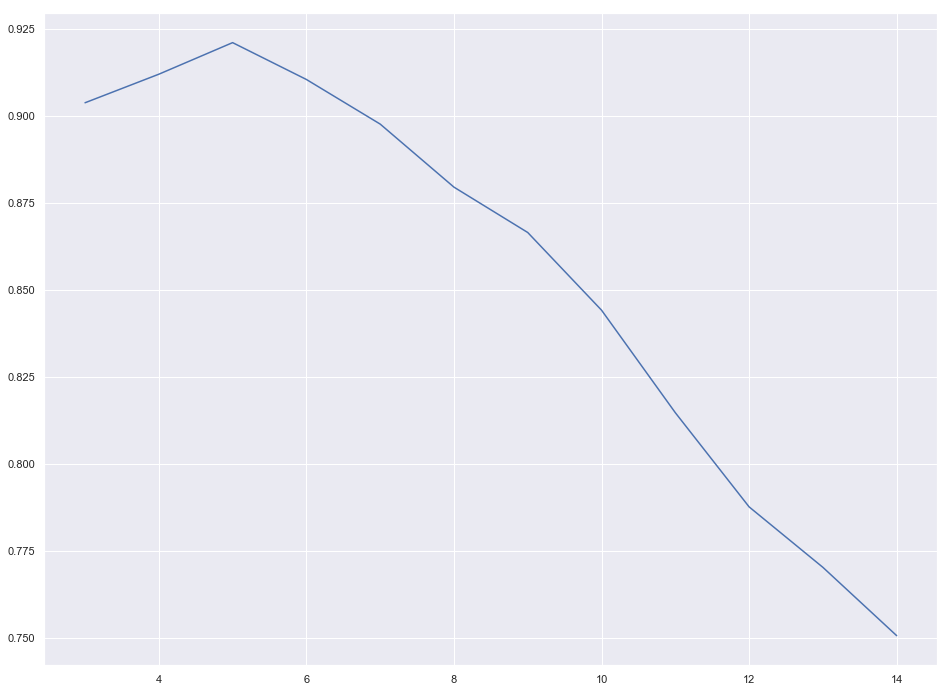

In [94]:
plt.rcParams['figure.figsize'] = (16, 12)
plt.plot(list(range(3,15)), tree_scores);

In [95]:
# CV check
tree_cv = cross_val_score(tree, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
tree_cv_best = tree_cv.mean()
print('Best result with Decision Tree: {}'.format(tree_cv_best.mean()))

Best result with Decision Tree: 0.7333365020781359


In [1]:
### Got best results with LogisticRegression 